# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/Virinchi2204/Superheroes)

## Task 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [1]:
!git clone https://github.com/Virinchi2204/Superheroes

Cloning into 'Superheroes'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 45.96 KiB | 1.39 MiB/s, done.


In [2]:
with open('Superheroes/superheroes.txt', 'r') as f:
  data=f.read()
data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [5]:
tokenizer.fit_on_texts(data)

In [6]:
char_to_index = tokenizer.word_index
index_to_char = dict((v,k) for k, v in char_to_index.items())
print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


## Task 3

1. Converting between names and sequences

In [7]:
names=data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [8]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [9]:
def NameToSequence(name):
  return[tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [10]:
NameToSequence(names[0])

[25, 16, 12, 20, 2, 1]

In [11]:
def SequenceToName(seq):
  return ''.join([index_to_char[i]for i in seq if i!=0])

In [12]:
SequenceToName(NameToSequence(names[0]))

'jumpa\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [13]:
from ast import Name
sequences=[]
for name in names:
  seq=NameToSequence(name)
  if len(seq)>=2:
    sequences += [seq[:i] for i in range(2, len(seq)+1)]

In [14]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [15]:
max_len=max([len(x)for x in sequences])
print(max_len)

33


In [16]:
padded_sequences=tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre',
    maxlen=max_len
)
print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [17]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [18]:
x, y = padded_sequences[:, :-1], padded_sequences[:, -1]
print(x.shape, y.shape)

(88279, 32) (88279,)


In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [20]:
num_chars=len(char_to_index.keys())+1
print(num_chars)

29


## Task 6: Creating the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense

model = Sequential([
    Embedding(num_chars, 8, input_length=max_len-1),
    Conv1D(64,5,strides=1, activation='tanh', padding='causal'),
    MaxPool1D(2),
    LSTM(32),
    Dense(num_chars, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
____________________________________________________

## Task 7: Training the Model

In [22]:
ttm=model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=40, verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    ]
)

Epoch 1/40
2070/2070 - 25s - loss: 2.7359 - accuracy: 0.1899 - val_loss: 2.6030 - val_accuracy: 0.2252 - 25s/epoch - 12ms/step
Epoch 2/40
2070/2070 - 12s - loss: 2.5432 - accuracy: 0.2343 - val_loss: 2.5156 - val_accuracy: 0.2446 - 12s/epoch - 6ms/step
Epoch 3/40
2070/2070 - 11s - loss: 2.4740 - accuracy: 0.2544 - val_loss: 2.4636 - val_accuracy: 0.2551 - 11s/epoch - 5ms/step
Epoch 4/40
2070/2070 - 12s - loss: 2.4285 - accuracy: 0.2638 - val_loss: 2.4254 - val_accuracy: 0.2657 - 12s/epoch - 6ms/step
Epoch 5/40
2070/2070 - 13s - loss: 2.3920 - accuracy: 0.2741 - val_loss: 2.3997 - val_accuracy: 0.2741 - 13s/epoch - 6ms/step
Epoch 6/40
2070/2070 - 12s - loss: 2.3608 - accuracy: 0.2820 - val_loss: 2.3737 - val_accuracy: 0.2787 - 12s/epoch - 6ms/step
Epoch 7/40
2070/2070 - 12s - loss: 2.3337 - accuracy: 0.2884 - val_loss: 2.3574 - val_accuracy: 0.2828 - 12s/epoch - 6ms/step
Epoch 8/40
2070/2070 - 12s - loss: 2.3103 - accuracy: 0.2958 - val_loss: 2.3397 - val_accuracy: 0.2928 - 12s/epoch - 

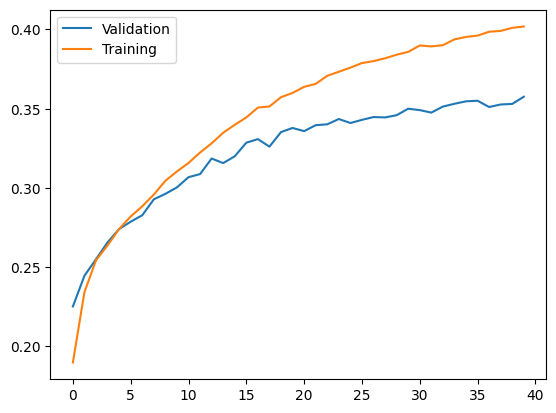

In [23]:
from matplotlib import pyplot as plt
epochs_ran = len(ttm.history['loss'])
plt.plot(range(0,epochs_ran), ttm.history['val_accuracy'], label='Validation')
plt.plot(range(0,epochs_ran), ttm.history['accuracy'], label='Training')
plt.legend()
plt.show()

## Task 8: Generate Names!

In [48]:
import random
def generate_names(letter):
  for i in range(0,40):
    seq = NameToSequence(letter)
    padded=tf.keras.preprocessing.sequence.pad_sequences([seq],padding='pre', maxlen=max_len-1, truncating='pre')
    pred=model.predict(padded)[0]
    pred_char=index_to_char[tf.argmax(pred).numpy()]
    # pred_weights = pred[:len(index_to_char)]
    # pred_char=random.choices(list(index_to_char.values()), weights=pred_weights, k=1)[0]
    letter+=pred_char
    if pred_char=='\t':
      break
  print(letter)

In [49]:
user_input = input("Enter a letter: ")

Enter a letter: p


In [50]:
generate_names(user_input.lower())

1/1 [==============================] - 0s 21ms/step
princess the sarger	
